In [1]:
#basic package
import os
import numpy as np
import pandas as pd
import sys
import time
import datetime as dt
import pickle

#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import kmeans_clustering, sampen, chi2_distance, ts_visual, correct_key, chi2_distance, most_frequent, mssd
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


In [3]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
id_run = config.id_run
path_extracted_data_adap = os.path.join(path_extracted_data,'Adaptability')
print(id_run)

change the configuration file if not done yet!
ALLDATA_


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Download data

In [4]:
#selected animals
li_selected_hens = pickle.load(open(os.path.join(path_extracted_data_adap, 'li_selected_hens.pkl'), 'rb'))
print(len(li_selected_hens))

133


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
#focal birds info to control for initial weight and rearingPenID
df_FB = pd.read_csv(os.path.join(config.path_extracted_data, id_run+'df_FOCALBIRDS.csv'), sep=';')
df_FB['early_death'] = df_FB['early_death'].fillna(0).replace(2,1) #2 means not sure
df_FB.rename(columns={'29-09 weight':'InitialWeight','R-Pen':'RearingPenID'}, inplace=True)
display(df_FB['early_death'].value_counts())
print(df_FB.shape)
df_FB.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.0    222
1.0     10
Name: early_death, dtype: int64

(232, 14)


,HenID,PenID,CLASS,RearingPenID,InitialStartDate,early_death,InitialWeight,10-12 juin weight,weight 23-11-2020,weight 04-01-2021,weight 01-02-21,weight 12-04-21,weight 26-07-21,Treatment
0,hen_1,pen9,EPI,1.0,2020-06-10,0.0,1134.0,57.0,1696.5,1787.8,1800.9,NaN,NaN,OFH
1,hen_10,pen11,LEXP,1.0,2020-06-10,0.0,1070.0,70.4,1488.3,1628.4,1602.1,1587.2,1713.4,OFH
2,hen_100,pen5,EPI,3.0,2020-06-10,0.0,1182.0,80.5,1642.5,NaN,NaN,NaN,NaN,OFH


In [6]:
#daily movement variables
df_MVT_ALL = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables_verified.csv'), sep=';', 
                     parse_dates=['level'], dayfirst=True) 
print(df_MVT_ALL.shape)
df_MVT_ALL = df_MVT_ALL[df_MVT_ALL['HenID'].isin(li_selected_hens)]
#restrict to the adaptability study timeframe
df_MVT_ALL = df_MVT_ALL[df_MVT_ALL['level']<=config.max_date_adaptability]
dico_cl = {'EPI':'Other','MEXP':'MEXP','LEXP':'LEXP','LEXPLOST':'Other','MEXPLOST':'Other'}
df_MVT_ALL['CLASS'] = df_MVT_ALL['CLASS'].map(lambda x: dico_cl[x])
display(df_MVT_ALL['CLASS'].value_counts())
#make sure we have their mvt
df_MVT_ALL = df_MVT_ALL[~df_MVT_ALL['perc_duration_5_Zone'].isnull()]
print(df_MVT_ALL.shape)
df_MVT_ALL.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(42300, 63)


Other    3246
MEXP     1673
LEXP     1304
Name: CLASS, dtype: int64

(6223, 63)


,HenID,PenID,CLASS,TagID,FocalLegringName,R-Pen,InitialStartDate,Treatment,level,DIB,...,percChaoticTransition,night_Max_duration_zones,is_mvt_night,empproba_3_Zone,empproba_4_Zone,empproba_2_Zone,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open,SleepingHeight
3,hen_131,pen10,Other,tag_128,19black,4.0,2020-06-10 00:00:00,TRAN,2020-09-30,1,...,0.0,5_Zone,1.0,0.000000,0.000000,100.0,NaN,NaN,NaN,5
4,hen_131,pen10,Other,tag_128,19black,4.0,2020-06-10 00:00:00,TRAN,2020-10-01,2,...,0.0,3_Zone,1.0,33.333333,50.000000,100.0,NaN,NaN,NaN,3
5,hen_131,pen10,Other,tag_128,19black,4.0,2020-06-10 00:00:00,TRAN,2020-10-02,3,...,8.0,5_Zone,0.0,33.333333,66.666667,100.0,NaN,NaN,NaN,5


In [7]:
#weather conditions
path_weather = os.path.join(r'C:\Users\camil\Desktop\vm_exchange\PhD_Data\Weather','Weather_process.csv')
df_weather_h = pd.read_csv(path_weather, sep=';', parse_dates=['date','Timestamp'])
df_weather_h = df_weather_h.sort_values('Timestamp') 
df_weather_h = df_weather_h.drop(['date'], axis=1)
df_weather_h['Timestamp_weather'] = df_weather_h['Timestamp'].copy()
print(df_weather_h.shape)
display(df_weather_h.head(3))

(7293, 13)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Timestamp,temperature,humidity,wind speed,Precipitation amount,query,Moon Phase calculator,hour,temperature_C,wind_speed_mpers,humidity_avgpercent,rain,Timestamp_weather
0,2020-09-29 00:00:00,"10 °C\n(12:00 am CEST | Tuesday, September 29,...",average: 100% (100%)\n(12:00 am CEST | Tuesday...,"2 m/s\n(12:00 am CEST | Tuesday, September 29,...","rain\n(12:00 am CEST | Tuesday, September 29, ...","Moon Phase calculatorSeptember 29, 2020 0h",| waxing gibbous moon\n91.87% illuminated,0,10,2,100,rain,2020-09-29 00:00:00
1,2020-09-29 01:00:00,"10 °C\n(1:00 am CEST | Tuesday, September 29, ...","average: 100% (100%)\n(1:00 am CEST | Tuesday,...","3 m/s\n(1:00 am CEST | Tuesday, September 29, ...","rain\n(1:00 am CEST | Tuesday, September 29, 2...","Moon Phase calculatorSeptember 29, 2020 1h",| waxing gibbous moon\n92.09% illuminated,1,10,3,100,rain,2020-09-29 01:00:00
2,2020-09-29 02:00:00,"10 °C\n(2:00 am CEST | Tuesday, September 29, ...","average: 100% (100%)\n(2:00 am CEST | Tuesday,...","3 m/s\n(2:00 am CEST | Tuesday, September 29, ...","rain\n(2:00 am CEST | Tuesday, September 29, 2...","Moon Phase calculatorSeptember 29, 2020 2h",| waxing gibbous moon\n92.30% illuminated,2,10,3,100,rain,2020-09-29 02:00:00


# Add external temperature as environemntal factor

In [8]:
#check variation over the day... exist very much
df_weather_h['date'] = df_weather_h['Timestamp'].map(lambda x: dt.datetime.date(x))
df_wday = df_weather_h[df_weather_h['hour'].isin([11,12,13,14,15,16])].groupby(['date'])['temperature_C'].agg(lambda x: list(x)).reset_index()
df_wday['temperature_C_avg'] = df_wday['temperature_C'].map(lambda x: np.mean(x))
df_wday.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,temperature_C,temperature_C_avg
0,2020-09-29,"[11, 12, 12, 12, 12, 13]",12.0
1,2020-09-30,"[10, 11, 13, 13, 14, 14]",12.5
2,2020-10-01,"[13, 15, 15, 15, 15, 14]",14.5


In [9]:
print(df_MVT_ALL.shape)
df_MVT_ALL['date'] = df_MVT_ALL['level'].map(lambda x: dt.datetime.date(x))
df_MVT_ALL = pd.merge(df_MVT_ALL, df_wday, on='date', how='left')
print(df_MVT_ALL.shape)
df_MVT_ALL.head(2)

(6223, 63)
(6223, 66)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,PenID,CLASS,TagID,FocalLegringName,R-Pen,InitialStartDate,Treatment,level,DIB,...,empproba_3_Zone,empproba_4_Zone,empproba_2_Zone,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open,SleepingHeight,date,temperature_C,temperature_C_avg
0,hen_131,pen10,Other,tag_128,19black,4.0,2020-06-10 00:00:00,TRAN,2020-09-30,1,...,0.000000,0.0,100.0,NaN,NaN,NaN,5,2020-09-30,"[10, 11, 13, 13, 14, 14]",12.5
1,hen_131,pen10,Other,tag_128,19black,4.0,2020-06-10 00:00:00,TRAN,2020-10-01,2,...,33.333333,50.0,100.0,NaN,NaN,NaN,3,2020-10-01,"[13, 15, 15, 15, 15, 14]",14.5


# Add initial conditions (weight, rearingpenID)

In [10]:
print(df_MVT_ALL.shape)
df_MVT_ALL = pd.merge(df_MVT_ALL, df_FB[['HenID','RearingPenID','InitialWeight']], on='HenID', how='left')
print(df_MVT_ALL.shape)
df_MVT_ALL.head(2)

(6223, 66)
(6223, 68)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,PenID,CLASS,TagID,FocalLegringName,R-Pen,InitialStartDate,Treatment,level,DIB,...,empproba_2_Zone,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open,SleepingHeight,date,temperature_C,temperature_C_avg,RearingPenID,InitialWeight
0,hen_131,pen10,Other,tag_128,19black,4.0,2020-06-10 00:00:00,TRAN,2020-09-30,1,...,100.0,NaN,NaN,NaN,5,2020-09-30,"[10, 11, 13, 13, 14, 14]",12.5,4.0,1202.0
1,hen_131,pen10,Other,tag_128,19black,4.0,2020-06-10 00:00:00,TRAN,2020-10-01,2,...,100.0,NaN,NaN,NaN,3,2020-10-01,"[13, 15, 15, 15, 15, 14]",14.5,4.0,1202.0


# Select only needed variable and days & save

In [11]:
#ONLW since WG open to compare apples with apples
print(df_MVT_ALL.shape)
df_MVT = df_MVT_ALL[df_MVT_ALL['level']>=config.date_first_opening_WG]
df_MVT.shape

(6223, 68)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(5361, 68)

In [12]:
#df to do PCA on first observation per week per bird 
df_4pca = df_MVT.groupby(['WIB','HenID'])['DIB'].agg(lambda x: min(list(x))).reset_index()
print(df_4pca.shape)
df_4pca.head(3)
df_MVT['tobeusedPCA'] = df_MVT.apply(lambda x: int(df_4pca[(df_4pca['HenID']==x['HenID'])&\
                                                       (df_4pca['WIB']==x['WIB'])]['DIB'].values[0]==x['DIB']), axis=1)
display(df_MVT['tobeusedPCA'].value_counts())
#small verification: only one value per animal per week
#df_MVT[df_MVT['tobeusedPCA']].groupby(['WIB','HenID']).count().reset_index()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(928, 3)


<ipython-input-12-4b1cd8ba3b89>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MVT['tobeusedPCA'] = df_MVT.apply(lambda x: int(df_4pca[(df_4pca['HenID']==x['HenID'])&\


0    4433
1     928
Name: tobeusedPCA, dtype: int64

In [13]:
li_var = ['perc_duration_5_Zone', 'perc_duration_4_Zone','perc_duration_3_Zone', 'perc_duration_2_Zone','perc_1_Zone_while_WG_open',
          'nbr_stays_2_Zone_perh', 'nbr_stays_4_Zone_perh','nbr_stays_3_Zone_perh', 'nbr_stays_5_Zone_perh','nbr_stays_1_Zone_perh',
          'in_WG_15mnAfterOpening','distribution_entropy', 'SleepingHeight','vertical_travel_distance_perh']
df_MVT['in_WG_15mnAfterOpening'] = df_MVT['in_WG_15mnAfterOpening'].map(lambda x: int(x))
df_MVT.rename(columns={'R-Pen':'RPen'}, inplace=True)
df_MVT = df_MVT[['WIB','HenID','RPen', 'DIB','CLASS','TrackingSystemID','PenID','temperature_C_avg', 'Treatment',
                'tobeusedPCA','RearingPenID','InitialWeight']+li_var].copy()
df_MVT.to_csv(os.path.join(path_extracted_data_adap,'df_MVT_4individuality.csv'), index=False, sep=';')
df_MVT.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-13-6a51c77324a8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MVT['in_WG_15mnAfterOpening'] = df_MVT['in_WG_15mnAfterOpening'].map(lambda x: int(x))
C:\Users\camil\anaconda3\lib\site-packages\pandas\core\frame.py:4295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/p

,WIB,HenID,RPen,DIB,CLASS,TrackingSystemID,PenID,temperature_C_avg,Treatment,tobeusedPCA,...,perc_1_Zone_while_WG_open,nbr_stays_2_Zone_perh,nbr_stays_4_Zone_perh,nbr_stays_3_Zone_perh,nbr_stays_5_Zone_perh,nbr_stays_1_Zone_perh,in_WG_15mnAfterOpening,distribution_entropy,SleepingHeight,vertical_travel_distance_perh
7,2,hen_131,4.0,11,Other,TrackingSystem 10-12,pen10,11.500000,TRAN,1,...,0.0,0.9,0.4,1.0,0.3,0.0,0,1.163814,5,2.5
8,2,hen_131,4.0,12,Other,TrackingSystem 10-12,pen10,10.166667,TRAN,0,...,0.0,0.9,0.2,1.0,0.1,0.0,0,1.140001,5,2.1
9,2,hen_131,4.0,13,Other,TrackingSystem 10-12,pen10,9.000000,TRAN,0,...,0.0,0.6,0.5,0.8,0.4,0.0,0,1.738025,3,2.4


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


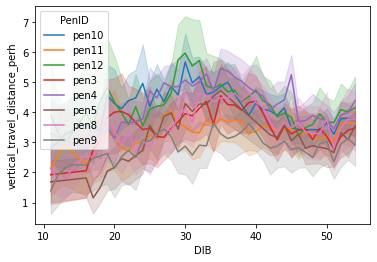

In [14]:
sns.lineplot(y='vertical_travel_distance_perh', x='DIB', data=df_MVT, hue='PenID');#,legend=False);